# 1. Loading the dataset, basic information

## 1.0. Imports

In [1]:
# Analiza na podatoci
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Pretprocesiranje
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.feature_selection import chi2

# Clustering algorithms
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture

# Supervised
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


# Metriki
from sklearn.metrics import (silhouette_score, davies_bouldin_score, calinski_harabasz_score,
                           adjusted_rand_score, normalized_mutual_info_score,
                           homogeneity_completeness_v_measure, mean_squared_error, roc_auc_score, precision_recall_curve)

# Avtoenkoder
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam


# Statisticka analiza
import scipy.stats as stats
from scipy.cluster.hierarchy import dendrogram, linkage

# Sminkanje :)
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

2025-06-15 09:20:23.933787: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 1.1. Opening the CSV file
Since this is a student project, we took a processed PCAP file that has already been converted to CSV with the needed features instead of capturing network packets and labeling them ourselves.

In [2]:
df = pd.read_csv('/home/bojan/Desktop/FEIT/6semestar/BZKKSiM/sem/TrafficLabelling /Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv')

## 1.2. Basic dataset info

In [3]:
print("=== PREGLED NA DATASETOT ===")
print(f"Broj na instanci: {len(df):,}")
print(f"Koloni: {df.shape[1]}")
print(f"Datatipovi:\n{df.dtypes.value_counts()}")

# Missing vrednosti
print("\n=== MISSING VREDNOSTI ===")
missing_data = df.isna().sum()
if missing_data.sum() > 0:
    print(missing_data[missing_data > 0].sort_values(ascending=False))
else:
    print("Nema missing values!")

# Deskriptivni statistiki
df.describe()

=== PREGLED NA DATASETOT ===
Broj na instanci: 225,745
Koloni: 85
Datatipovi:
int64      56
float64    24
object      5
Name: count, dtype: int64

=== MISSING VREDNOSTI ===
Flow Bytes/s    4
dtype: int64


,Source Port,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,225745.000000,225745.00000,225745.000000,2.257450e+05,225745.000000,225745.000000,225745.000000,2.257450e+05,225745.000000,225745.000000,...,225745.000000,225745.000000,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05
mean,38257.568402,8879.61946,7.600288,1.624165e+07,4.874916,4.572775,939.463346,5.960477e+03,538.535693,27.882221,...,3.311497,21.482753,1.848261e+05,1.293436e+04,2.080849e+05,1.776201e+05,1.032214e+07,3.611943e+06,1.287813e+07,7.755355e+06
std,23057.302075,19754.64740,3.881586,3.152437e+07,15.422874,21.755356,3249.403484,3.921834e+04,1864.128991,163.324159,...,12.270018,4.166799,7.979250e+05,2.102737e+05,9.002350e+05,7.842602e+05,2.185303e+07,1.275689e+07,2.692126e+07,1.983109e+07
min,0.000000,0.00000,0.000000,-1.000000e+00,1.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,...,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,18990.000000,80.00000,6.000000,7.118000e+04,2.000000,1.000000,26.000000,0.000000e+00,6.000000,0.000000,...,1.000000,20.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,49799.000000,80.00000,6.000000,1.452333e+06,3.000000,4.000000,30.000000,1.640000e+02,20.000000,0.000000,...,2.000000,20.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,58296.000000,80.00000,6.000000,8.805237e+06,5.000000,5.000000,63.000000,1.160100e+04,34.000000,6.000000,...,4.000000,20.000000,1.878000e+03,0.000000e+00,1.878000e+03,1.862000e+03,8.239725e+06,0.000000e+00,8.253838e+06,7.422849e+06
max,65534.000000,65532.00000,17.000000,1.199999e+08,1932.000000,2942.000000,183012.000000,5.172346e+06,11680.000000,1472.000000,...,1931.000000,52.000000,1.000000e+08,3.950000e+07,1.000000e+08,1.000000e+08,1.200000e+08,6.530000e+07,1.200000e+08,1.200000e+08


## 1.3. Analysis of the target variable (DDoS vs. benign packet)

=== RASPREDELBA NA LABELATA ===
 Label
DDoS      128027
BENIGN     97718
Name: count, dtype: int64

Percentages:
 Label
DDoS      56.71
BENIGN    43.29
Name: count, dtype: float64


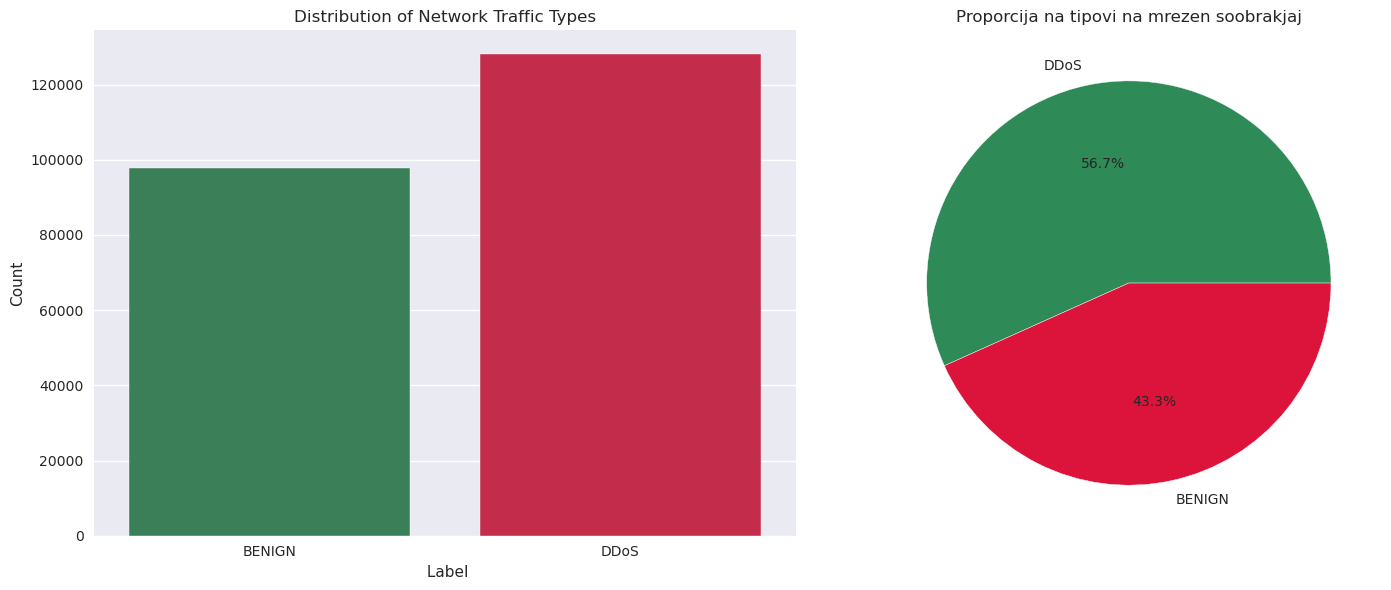

In [4]:
# Raspredelba
print("=== RASPREDELBA NA LABELATA ===")
label_counts = df[' Label'].value_counts()
print(label_counts)
print(f"\nPercentages:")
print((label_counts / len(df) * 100).round(2))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# countplot
COLORS = {
    'benign': '#2E8B57',    # bledo zelenko
    'ddos': '#DC143C',      # crvenuskavo
    'cluster_0': '#1f77b4', # sino
    'cluster_1': '#ff7f0e'  # port
}
sns.countplot(data=df, x=' Label', ax=ax1, palette=[COLORS['benign'], COLORS['ddos']])
ax1.set_title('Distribution of Network Traffic Types')
ax1.set_ylabel('Count')

# pita
ax2.pie(label_counts.values, labels=label_counts.index, autopct='%1.1f%%',
        colors=[COLORS['benign'], COLORS['ddos']])
ax2.set_title('Proporcija na tipovi na mrezen soobrakjaj')

plt.tight_layout()
plt.show()

We can infer that the dataset is pretty balanced and even has more instances that belong to the POSITIVE (DDoS) class.

We will use two approaches later on. The data is temporal, so we will train on earlier time range, and test on the later time range. It also helps that the data is already sorted by time with the Timestamp column, so we needn't sort it. We can move onto preprocessing our data.

# 2. Data preprocessing

## 2.1. Missing & infinite values

### 2.1.1. Missing values
We have already counted the missing values (NaN) in the basic data info subsection above, and we found out that the number of NaN values is 4. In a dataset of 200,000+ values this is insignificant so we will drop those.

In [5]:
print(f"Before: {df.shape}")
df.dropna(inplace=True)
print(f"After: {df.shape}")

Before: (225745, 85)
After: (225741, 85)


### 2.1.2. Infinite values
We notice that in the descriptive statistics df, some infinite values were present as well. Let's count them up first (per column)

In [6]:
numdtype_cols = list(df.select_dtypes(include=['number']).columns)
inf_counts = np.isinf(df[numdtype_cols]).sum()
print("=== INFINITE VALUE COUNTS PER COLUMN ===")
print(inf_counts[inf_counts > 0])  # Show only affected columns

=== INFINITE VALUE COUNTS PER COLUMN ===
Flow Bytes/s       30
 Flow Packets/s    30
dtype: int64


Only two features have infinite values. Even though they are few, we will not remove them as they might contain valuable information (DDoS is after all, characterized by sudden surges or traffic floods). Instead, we opt to replace them with the maximum finite value in their respective columns.

In [7]:
split_point = int(0.8 * len(df))
for col in ['Flow Bytes/s',' Flow Packets/s']:
    if df[col].dtype in [np.float64, np.int64]:
        if np.isinf(df[col]).any():
            max_val = df.iloc[:split_point][~np.isinf(df[col])][col].max()
            df[col] = df[col].replace(np.inf, max_val)
            df[col] = df[col].replace(-np.inf, -max_val)

Let's check our newly imputed dataframe.

In [8]:
df.describe()

,Source Port,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,225741.000000,225741.000000,225741.000000,2.257410e+05,225741.000000,225741.000000,225741.000000,2.257410e+05,225741.000000,225741.000000,...,225741.000000,225741.000000,2.257410e+05,2.257410e+05,2.257410e+05,2.257410e+05,2.257410e+05,2.257410e+05,2.257410e+05,2.257410e+05
mean,38257.692732,8879.294213,7.600316,1.624194e+07,4.874972,4.572851,939.479993,5.960583e+03,538.545235,27.882715,...,3.311556,21.482513,1.848294e+05,1.293459e+04,2.080886e+05,1.776232e+05,1.032233e+07,3.612007e+06,1.287836e+07,7.755493e+06
std,23057.356587,19754.491905,3.881615,3.152458e+07,15.423004,21.755541,3249.429866,3.921868e+04,1864.144128,163.325564,...,12.270118,4.166390,7.979317e+05,2.102755e+05,9.002425e+05,7.842668e+05,2.185318e+07,1.275700e+07,2.692145e+07,1.983124e+07
min,0.000000,0.000000,0.000000,-1.000000e+00,1.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,...,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,18990.000000,80.000000,6.000000,7.118300e+04,2.000000,1.000000,26.000000,0.000000e+00,6.000000,0.000000,...,1.000000,20.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,49799.000000,80.000000,6.000000,1.452362e+06,3.000000,4.000000,30.000000,1.640000e+02,20.000000,0.000000,...,2.000000,20.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,58296.000000,80.000000,6.000000,8.805245e+06,5.000000,5.000000,63.000000,1.160100e+04,34.000000,6.000000,...,4.000000,20.000000,1.878000e+03,0.000000e+00,1.878000e+03,1.862000e+03,8.239754e+06,0.000000e+00,8.253869e+06,7.422871e+06
max,65534.000000,65532.000000,17.000000,1.199999e+08,1932.000000,2942.000000,183012.000000,5.172346e+06,11680.000000,1472.000000,...,1931.000000,52.000000,1.000000e+08,3.950000e+07,1.000000e+08,1.000000e+08,1.200000e+08,6.530000e+07,1.200000e+08,1.200000e+08


## 2.2. Variance analysis
We notice that some of features have 0.0 standard deviation. This means that those features have constant values which means they do not carry any information so we can drop them.

In [9]:
zero_var_cols = [col for col in numdtype_cols if df[col].std() < 1e-14]
print(zero_var_cols)

[' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags', ' CWE Flag Count', 'Fwd Avg Bytes/Bulk', ' Fwd Avg Packets/Bulk', ' Fwd Avg Bulk Rate', ' Bwd Avg Bytes/Bulk', ' Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate']


In [10]:
df.drop(zero_var_cols, axis=1, inplace=True)
print(df.shape)

(225741, 75)


We dropped 10 columns. Next, let's analyze the remaining data and see if the variability is low compared to the full range (stdev/range). If this normalized stdev is low, then the feature distribution is pretty centered, meaning it has low variance relative to its true range, hence it is droppable.

In [11]:
numdtype_cols = list(df.select_dtypes(include=['number']).columns)

for col in numdtype_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    no_max = Q3 + 1.5*IQR
    no_min = Q1 - 1.5*IQR
    robust_range = no_max - no_min
    stdev = df[col].std()
    variability = stdev/robust_range
    print(f"{col} variability: {variability}")

 Source Port variability: 0.14665290659535782
 Destination Port variability: inf
 Protocol variability: inf
 Flow Duration variability: 0.9023458784412959
 Total Fwd Packets variability: 1.285250373040887
 Total Backward Packets variability: 1.3597213035436246
Total Length of Fwd Packets variability: 21.955607205340836
 Total Length of Bwd Packets variability: 0.845157246859092
 Fwd Packet Length Max variability: 16.644144000068078
 Fwd Packet Length Min variability: 6.805231818463112
 Fwd Packet Length Mean variability: 4.854778471183391
 Fwd Packet Length Std variability: 19.424190345259095
Bwd Packet Length Max variability: 0.15861037637423975
 Bwd Packet Length Min variability: 2.1033735775717073
 Bwd Packet Length Mean variability: 0.1447827054561334
 Bwd Packet Length Std variability: 0.17781366913883886
Flow Bytes/s variability: 338.49155347186075
 Flow Packets/s variability: 429.98560762017775
 Flow IAT Mean variability: 0.3386707020162254
 Flow IAT Std variability: 0.474749970

Even though some features have low variability based on their standard deviation and boxplot range, we're not removing them. A lot of these are flag columns - like SYN, FIN, or ACK; and just because they don’t change much doesn’t mean they’re useless. In fact, that’s kind of the point: when they do flip, it could be a sign something sketchy is happening. So we're keeping them, because low variability doesn’t always mean low importance, especially in anomaly detection where those rare changes might be the exact red flags we're looking for.

## 2.3. Scaling

We will use a robust scaler approach as robust scaling preserves outliers whereas standard scaling squashes them. Just to check that the features are generally skewed and therefore appropriate for robust scaling, we will calculate the skewness of each feature.

In [12]:
binary_cols = [col for col in df.columns if df[col].nunique() == 2]
num_cols_to_scale = [col for col in numdtype_cols if col not in binary_cols and col not in [' Source Port',' Destination Port', ' Protocol']]

for col in num_cols_to_scale:
    skew = df[col].skew()
    print(f"{col} skew: {skew}")

 Flow Duration skew: 1.9419695537508708
 Total Fwd Packets skew: 59.63653298281573
 Total Backward Packets skew: 66.21126792369441
Total Length of Fwd Packets skew: 7.5222335624551055
 Total Length of Bwd Packets skew: 69.59666523221289
 Fwd Packet Length Max skew: 4.087974160401761
 Fwd Packet Length Min skew: 8.040546774611753
 Fwd Packet Length Mean skew: 3.31448250844234
 Fwd Packet Length Std skew: 4.229442812907225
Bwd Packet Length Max skew: 0.9989498673221507
 Bwd Packet Length Min skew: 10.433201532960892
 Bwd Packet Length Mean skew: 0.6756446775488093
 Bwd Packet Length Std skew: 1.1440753356759858
Flow Bytes/s skew: 61.393862534048644
 Flow Packets/s skew: 13.494824921702202
 Flow IAT Mean skew: 4.177613948600081
 Flow IAT Std skew: 2.1847840551039863
 Flow IAT Max skew: 2.081291817582138
 Flow IAT Min skew: 55.9227792453609
Fwd IAT Total skew: 1.9581226743420295
 Fwd IAT Mean skew: 6.539849671132073
 Fwd IAT Std skew: 2.1950146320554533
 Fwd IAT Max skew: 2.095154246496044

They are all pretty skewed (abs(skew)>0.5 if we use this as a threshold) so we will be using RobustScaler, but only on the features that are not binary (e.g. not on the flags)

In [13]:
scaler = RobustScaler()
scaler.fit(df.iloc[:split_point][num_cols_to_scale])
df[num_cols_to_scale] = scaler.transform(df[num_cols_to_scale])

In [14]:
df.describe()

,Source Port,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,225741.000000,225741.000000,225741.000000,225741.000000,225741.000000,225741.000000,225741.000000,225741.000000,225741.000000,225741.000000,...,225741.000000,225741.000000,225741.000000,2.257410e+05,225741.000000,225741.000000,225741.000000,2.257410e+05,225741.000000,225741.000000
mean,38257.692732,8879.294213,7.600316,1.494266,0.937486,0.095475,30.449333,0.496214,37.038945,4.647119,...,0.655778,1.482513,92.230223,1.293459e+04,103.836605,88.678600,1.084081,3.612007e+06,1.348378,0.967499
std,23057.356587,19754.491905,3.881615,3.266872,7.711502,3.625923,108.314329,3.380629,133.153152,27.220927,...,6.135059,4.166390,398.169527,2.102755e+05,449.222823,391.546087,2.295084,1.275700e+07,2.818704,2.473951
min,0.000000,0.000000,0.000000,-0.188876,-1.000000,-0.666667,-0.866667,-0.017585,-1.428571,0.000000,...,-1.000000,-20.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,18990.000000,80.000000,6.000000,-0.181499,-0.500000,-0.500000,0.000000,-0.017585,-1.000000,0.000000,...,-0.500000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
50%,49799.000000,80.000000,6.000000,-0.038368,0.000000,0.000000,0.133333,-0.003448,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
75%,58296.000000,80.000000,6.000000,0.723607,1.000000,0.166667,1.233333,0.982415,1.000000,1.000000,...,1.000000,0.000000,0.937126,0.000000e+00,0.937126,0.929606,0.865363,0.000000e+00,0.864189,0.926005
max,65534.000000,65532.000000,17.000000,12.246643,964.500000,489.666667,6099.533333,445.835876,832.857143,245.333333,...,964.500000,32.000000,49900.199601,3.950000e+07,49900.199601,49925.112332,12.602748,6.530000e+07,12.564128,14.970023


## 2.4. Encoding

In [15]:
cat_cols = [col for col in df.columns if col not in numdtype_cols]
print(cat_cols)

['Flow ID', ' Source IP', ' Destination IP', ' Timestamp', ' Label']


In [16]:
df[cat_cols]

,Flow ID,Source IP,Destination IP,Timestamp,Label
0,192.168.10.5-104.16.207.165-54865-443-6,104.16.207.165,192.168.10.5,7/7/2017 3:30,BENIGN
1,192.168.10.5-104.16.28.216-55054-80-6,104.16.28.216,192.168.10.5,7/7/2017 3:30,BENIGN
2,192.168.10.5-104.16.28.216-55055-80-6,104.16.28.216,192.168.10.5,7/7/2017 3:30,BENIGN
3,192.168.10.16-104.17.241.25-46236-443-6,104.17.241.25,192.168.10.16,7/7/2017 3:30,BENIGN
4,192.168.10.5-104.19.196.102-54863-443-6,104.19.196.102,192.168.10.5,7/7/2017 3:30,BENIGN
...,...,...,...,...,...
225740,192.168.10.15-72.21.91.29-61374-80-6,72.21.91.29,192.168.10.15,7/7/2017 5:02,BENIGN
225741,192.168.10.15-72.21.91.29-61378-80-6,72.21.91.29,192.168.10.15,7/7/2017 5:02,BENIGN
225742,192.168.10.15-72.21.91.29-61375-80-6,72.21.91.29,192.168.10.15,7/7/2017 5:02,BENIGN
225743,192.168.10.15-8.41.222.187-61323-80-6,8.41.222.187,192.168.10.15,7/7/2017 5:02,BENIGN


We have made the following decisions:
- drop FlowID: this decision is quite obvious as the flow-id is a key/identifier/index and as such has no modeling value.
- drop srcIP and destIP: one could decide to keep them and maybe encode them per subset, but for the sake of simplicity, we will attempt to capture patterns that are more universal instead of modeling unique per-host/per-subnet behavior.
- ordinal encoding on Timestamp (we will not be using this column in the model fitting later, but we will keep it for the temporal split before we drop it)
- binary encoding on Label (0 - benign; 1 - DDoS)

First, let's drop FlowID, srcIP, destIP:

In [17]:
drop_cols = ['Flow ID', ' Source IP', ' Destination IP']
df.drop(drop_cols, axis=1, inplace=True)

In [18]:
df[' Timestamp']

0         7/7/2017 3:30
1         7/7/2017 3:30
2         7/7/2017 3:30
3         7/7/2017 3:30
4         7/7/2017 3:30
              ...      
225740    7/7/2017 5:02
225741    7/7/2017 5:02
225742    7/7/2017 5:02
225743    7/7/2017 5:02
225744    7/7/2017 5:02
Name:  Timestamp, Length: 225741, dtype: object

The data is already sorted by time so the encoding is incredibly easy:

In [19]:
df[' Timestamp'] = range(len(df))
df[' Timestamp']

0              0
1              1
2              2
3              3
4              4
           ...  
225740    225736
225741    225737
225742    225738
225743    225739
225744    225740
Name:  Timestamp, Length: 225741, dtype: int64

Next, we will encode the label: benign -> 0; ddos -> 1.

In [20]:
labels = df[' Label'].unique().tolist()
labels

['BENIGN', 'DDoS']

In [21]:
df[' Label'] = df[' Label'].map({'BENIGN': 0, 'DDoS': 1})

enc_labels = df[' Label'].unique().tolist()
enc_labels

[0, 1]

In [22]:
df

,Source Port,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,443,54865,6,0,-0.188875,-0.5,-0.666667,-0.466667,-0.017585,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,80,55054,6,1,-0.188864,-1.0,-0.500000,-0.666667,-0.017067,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,80,55055,6,2,-0.188870,-1.0,-0.500000,-0.666667,-0.017067,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,443,46236,6,3,-0.188872,-1.0,-0.500000,-0.666667,-0.017067,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,443,54863,6,4,-0.188875,-0.5,-0.666667,-0.466667,-0.017585,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225740,80,61374,6,225736,-0.188869,-1.0,-0.500000,-0.666667,-0.017067,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
225741,80,61378,6,225737,-0.188868,-1.0,-0.500000,-0.666667,-0.017067,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
225742,80,61375,6,225738,-0.188868,-1.0,-0.500000,-0.666667,-0.017067,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
225743,80,61323,6,225739,-0.188870,-0.5,-0.666667,-0.466667,-0.017585,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


# 3. Exploratory data analysis & Inferential statistics

We will still be using the entire dataset here as this part is diagnostic which means there is no data leakage.

Parts in which we make decisions will only feature the first 80% of the dataset

## 3.1. Flow Duration, Size, and Rate Distributions

Let's first analyze the distribution of the flow duration of packets using a violin plot

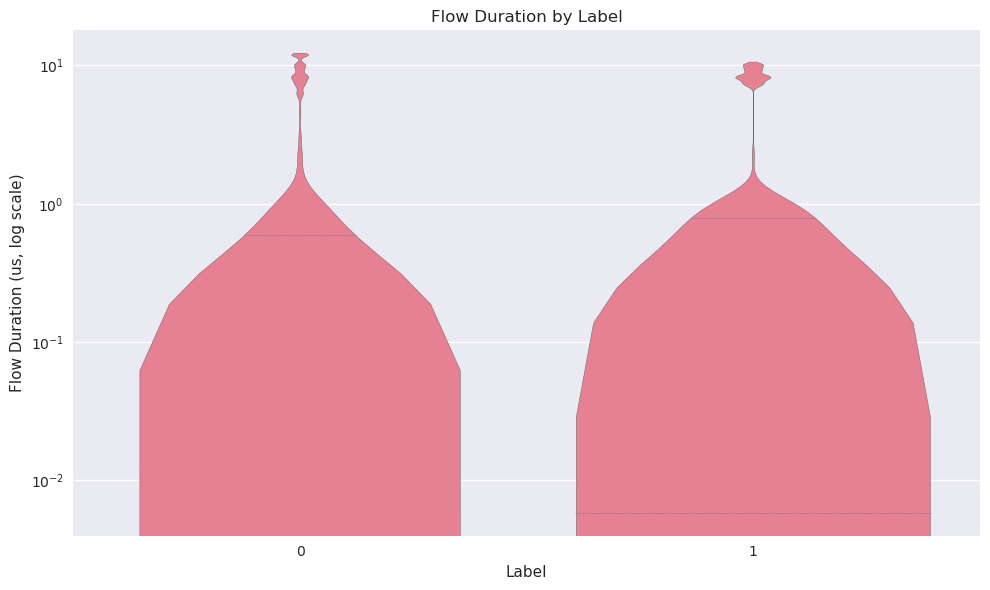

In [23]:
plt.figure(figsize=(10, 6))
sns.violinplot(data=df, x=' Label', y=' Flow Duration', inner='quartile', scale='width', cut=0)
plt.yscale('log')
plt.title('Flow Duration by Label')
plt.xlabel('Label')
plt.ylabel('Flow Duration (us, log scale)')
plt.tight_layout()
plt.show()

Both categories have very similar overall distribution shapes:
- heavily right-skewed.
- majority of flows cluster around very short durations.
- a few long-duration flows exist, forming the narrow spike at the top of each violin.

DDoS flows (1) appear even more compressed toward the bottom, suggesting more consistent, ultra-short bursts — classic DDoS behavior. The top end is slightly flatter, indicating fewer prolonged DDoS sessions.

Benign flows (0) have a more varied tail, hinting at some longer-lasting sessions — expected in real-world user interactions like browsing, video streaming, etc. This however seems insignificant.

Next, let's see the distribution of the total length of fwd packets by label.

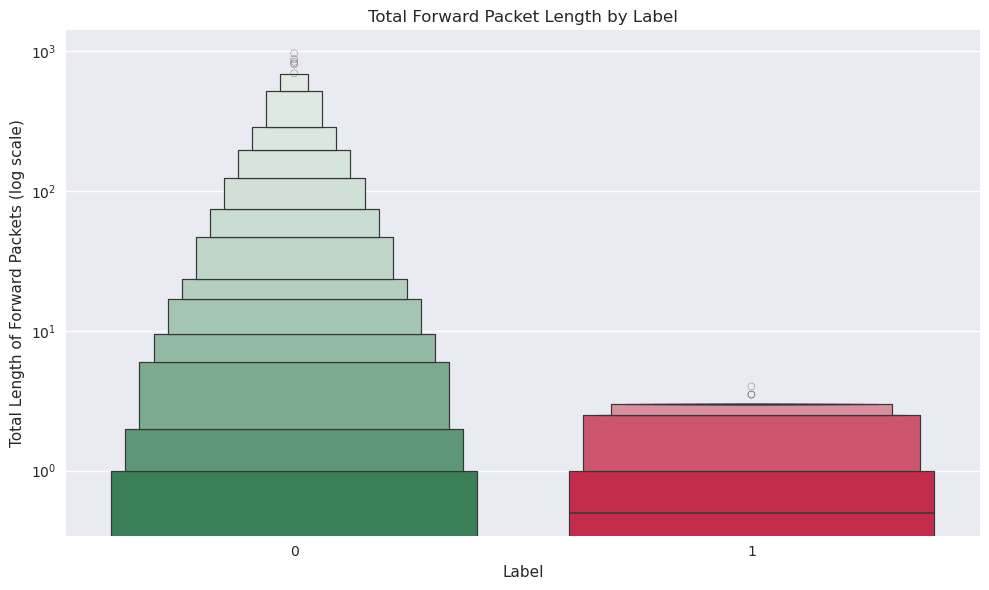

In [24]:
plt.figure(figsize=(10, 6))
sns.boxenplot(
    data=df,
    x=' Label',
    y=' Total Fwd Packets',
    palette=[COLORS['benign'], COLORS['ddos']],
    scale='linear'
)

plt.yscale('log')
plt.title('Total Forward Packet Length by Label')
plt.xlabel('Label')
plt.ylabel('Total Length of Forward Packets (log scale)')
plt.tight_layout()
plt.show()

🔸 Benign flows (0):
- Super broad range, going well past 1000 on the log scale.
- Boxenplot "stairs" go deep - we've got heavy tails, large packets, and lots of spread.
- Outliers (∘) are stacked high; consistent with normal traffic doing legit data transfers, like downloads, browsing, or large responses.

🔸 DDoS flows (1):
- Tight, compact distribution, rarely exceeding $10^2$.
- Almost all values are clustered within a narrow band near the bottom.
- This points to DDoS traffic using small, rapid-fire packets - often signature patterns like SYN floods or UDP floods with minimal payloads. This will be further explored in a further subsection of flag analysis.

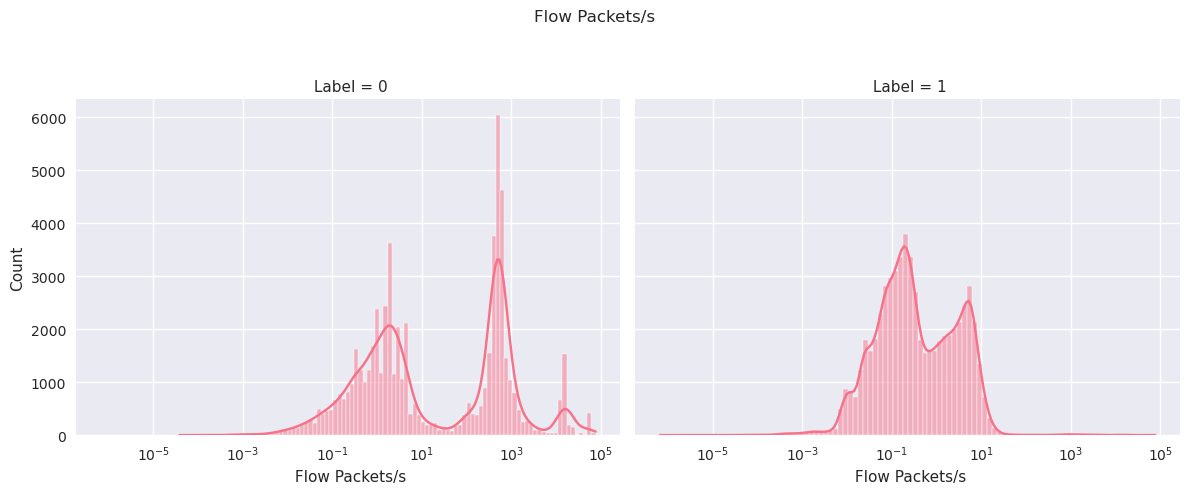

In [25]:
g = sns.FacetGrid(df, col=" Label", height=5, aspect=1.2)
g.map(sns.histplot, " Flow Packets/s", bins=100, kde=True, log_scale=True)
g.fig.subplots_adjust(top=0.8)
g.fig.suptitle('Flow Packets/s')
plt.show()

We can also see that the distributions of the packet rates are similarly shaped in that they are bimodal, but there are two things:
- the two modes of the benign class are significantly to the right (around $1$ and $2\cdot 10^2$ packets/s) meaning that the rates are usually faster. There's also an absence of high-throughput flows in the ddos class, which makes sense: many DDoS attacks favor a large number of small, distributed flows over individually high-speed connections.
- the two modes of the benign class are also significantly more extreme than the modes of the DDoS class - the flows tend to operate at more uniform rates, likely due to automation.

Finally, let's analyze the mean packet length per label using a violinplot.

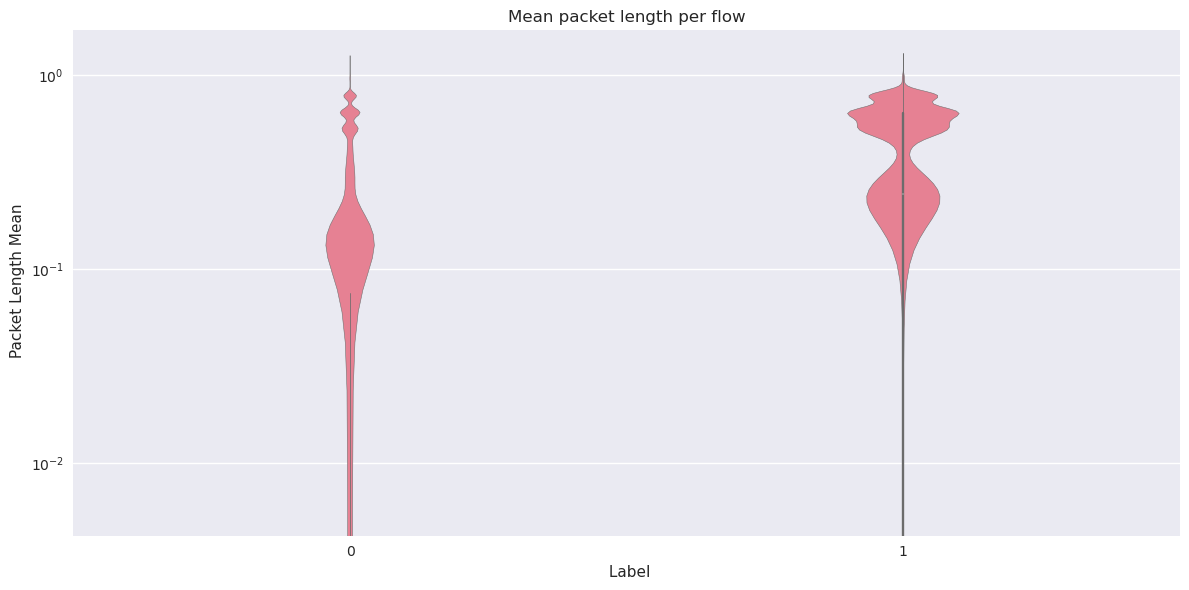

In [26]:
plt.figure(figsize=(12, 6))
sns.violinplot(data=df, x=' Label', y=' Packet Length Mean')
plt.yscale('log')
plt.title('Mean packet length per flow')
plt.tight_layout()
plt.show()

Benign traffic is unpredictable and full of variance - though most of the instances have a packet length below $10^{-1}$. But DDoS traffic is consistent, calculated, and rigid - same packet sizes over and over again. A clear sign of automated behavior.

## 3.2. Protocol and port analysis

Let's first analyze the distribution of the classes between the protocols.

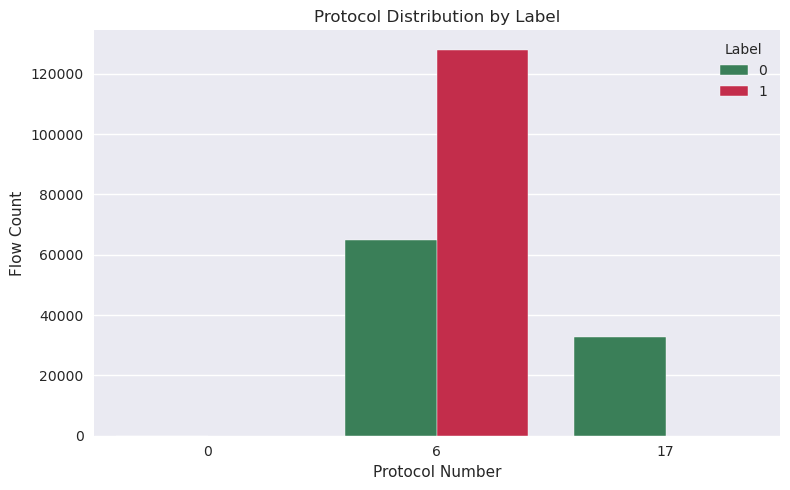

In [27]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x=' Protocol', hue=' Label', palette=[COLORS['benign'], COLORS['ddos']])
plt.title('Protocol Distribution by Label')
plt.xlabel('Protocol Number')
plt.ylabel('Flow Count')
plt.legend(title='Label')
plt.tight_layout()
plt.show()

We can see here that ALL DDoS attacks use protocol #6 (aka TCP) - i.e. that all DDoS attacks were SYN/ACK floods. This can be problematic because it can lead to shortcut learning. The model might see an instance that is actually a UDP flood (a DDoS attack that uses UDP) and automatically flag it as benign just because it uses a protocol that is not TCP. This is a flaw of the dataset, so it is a potentially undesirable feature in the spirit of generalization.

In [28]:
undesirables = []
undesirables.append(' Protocol')

Next, let's analyze the ports:

<Figure size 1000x700 with 0 Axes>

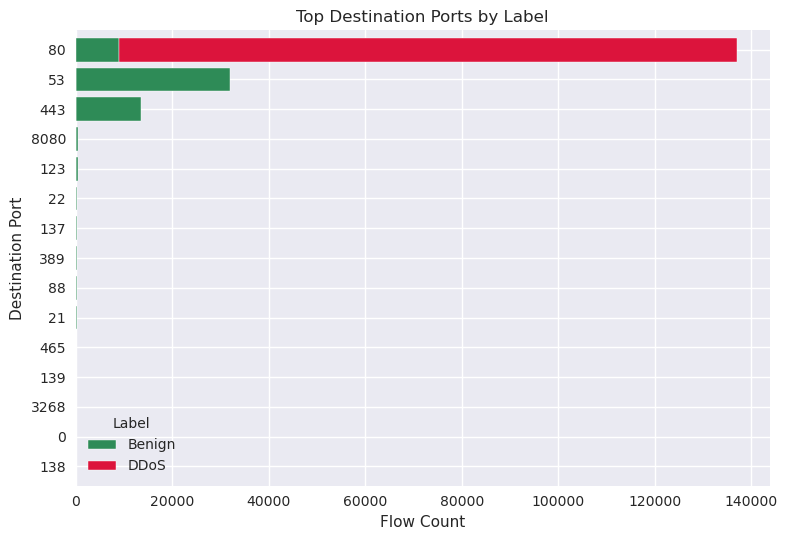

In [29]:
import matplotlib.pyplot as plt

# Najcestite 15 porti
top_ports = df[' Destination Port'].value_counts().head(15).index

# Crosstab na portite i labelata
port_label_counts = pd.crosstab(df[' Destination Port'], df[' Label'])
port_label_counts = port_label_counts.loc[top_ports]  # samo 15te

plt.figure(figsize=(10, 7))
port_label_counts[[0, 1]].plot(kind='barh',
                               stacked=True,
                               color=[COLORS['benign'], COLORS['ddos']],
                               width=0.8)

plt.title('Top Destination Ports by Label')
plt.xlabel('Flow Count')
plt.ylabel('Destination Port')
plt.legend(title='Label', labels=['Benign', 'DDoS'])
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


Another fundamental flaw of this dataset is that all the DDoS attacks are HTTP-based (they use port 80). This also won't generalize well, so it is fairer to just mark this feature as undersiable as well, because DDoS attacks that use other ports DO exist and even though these two features will immensely improve the performance even for our particular test set, they wouldn't generalize well for an online model. This is to ensure a more robust and fair performance.

In [30]:
undesirables.append(' Destination Port')

## 3.3. Feature correlation and redundancy analysis

Here, we will only plot a heatmap of the most correlated features because 75 features is too many to plot.

In [31]:
# samo na trening podatoci
train_df = df.iloc[:split_point]

corr_matrix = train_df.select_dtypes(include='number').corr().abs() #aps vrednost bidejki i da e -1 se visoko korelirani samo negativno

upper = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
upper_matrix = corr_matrix.where(upper)

high_corr = upper_matrix.stack().reset_index()
high_corr.columns = ['Feature 1', 'Feature 2', 'Correlation']
high_corr = high_corr[high_corr['Correlation'] > 0.95].sort_values(by='Correlation', ascending=False)

high_corr

,Feature 1,Feature 2,Correlation
997,Bwd Packet Length Mean,Avg Bwd Segment Size,1.000000
461,Total Backward Packets,Subflow Bwd Packets,1.000000
394,Total Fwd Packets,Subflow Fwd Packets,1.000000
524,Total Length of Fwd Packets,Subflow Fwd Bytes,1.000000
1872,Fwd Header Length,Fwd Header Length.1,1.000000
766,Fwd Packet Length Mean,Avg Fwd Segment Size,1.000000
2208,RST Flag Count,ECE Flag Count,1.000000
1825,Fwd PSH Flags,SYN Flag Count,1.000000
589,Total Length of Bwd Packets,Subflow Bwd Bytes,1.000000
2070,Packet Length Mean,Average Packet Size,0.999372


In [32]:
for i in range(len(high_corr)):
    f1 = high_corr.iloc[i]['Feature 1']
    f2 = high_corr.iloc[i]['Feature 2']
    if f1 not in undesirables and f2 not in undesirables:
        undesirables.append(f1)

In [33]:
len(undesirables)

27

We notice 34 columns that are potentially removable

## 3.4. Flag behaviour

In [34]:
flag_cols = [col for col in df.columns if 'Flag' in col and df[col].nunique() == 2]

flag_cols

['Fwd PSH Flags',
 'FIN Flag Count',
 ' SYN Flag Count',
 ' RST Flag Count',
 ' PSH Flag Count',
 ' ACK Flag Count',
 ' URG Flag Count',
 ' ECE Flag Count']

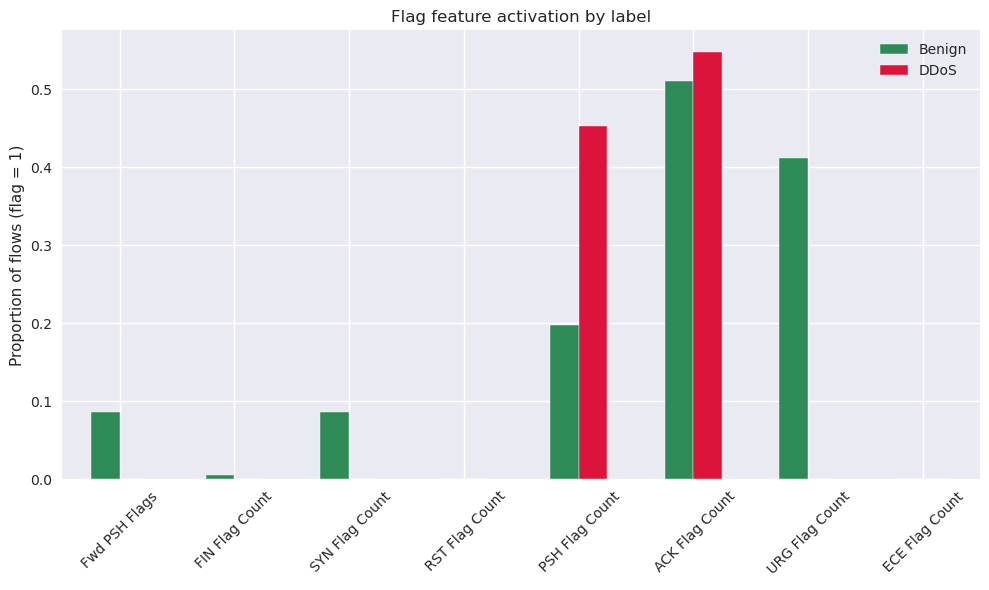

In [35]:
flag_means = df.iloc[:split_point].groupby(' Label')[flag_cols].mean().T
flag_means.columns = ['Benign', 'DDoS']
flag_means.plot(kind='bar', figsize=(10, 6), color=[COLORS['benign'], COLORS['ddos']])
plt.title('Flag feature activation by label')
plt.ylabel('Proportion of flows (flag = 1)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

We notice that the majority of DDoS attack instances are PSH/ACK floods. Let's analyze both

In [36]:
ack_floods = df[(df[' Label'] == 1) & (df[' ACK Flag Count'] > 0)]
ack_floods

,Source Port,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
18884,49650,80,6,18881,0.269310,0.5,-0.666667,-0.066667,-0.017585,-1.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1
18886,51684,80,6,18883,8.105035,2.5,0.000000,1.000000,0.982415,0.0,...,0.0,0.468563,0.0,0.468563,0.468797,4.127400,44200000.0,7.391895,1.007066,1
18888,51686,80,6,18885,8.073673,2.5,0.166667,1.000000,0.982415,0.0,...,0.0,0.454591,0.0,0.454591,0.454818,4.116898,44400000.0,7.391895,0.968873,1
18890,51687,80,6,18887,8.078714,2.5,0.000000,1.000000,0.982933,0.0,...,0.0,0.437625,0.0,0.437625,0.437843,4.137902,44800000.0,7.444246,0.967499,1
18892,51688,80,6,18889,8.008069,2.5,0.333333,1.000000,0.982933,0.0,...,0.0,0.368762,0.0,0.368762,0.368947,4.106395,45300000.0,7.444246,0.882473,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197534,43197,80,6,197531,-0.172723,0.5,-0.666667,-0.066667,-0.017585,-1.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1
197536,43198,80,6,197533,-0.171671,0.5,-0.666667,-0.066667,-0.017585,-1.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1
197538,43199,80,6,197535,-0.171976,0.5,-0.666667,-0.066667,-0.017585,-1.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1
197540,43200,80,6,197537,-0.172350,0.5,-0.666667,-0.066667,-0.017585,-1.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1


In [37]:
psh_floods = df[(df[' Label'] == 1) & (df[' PSH Flag Count'] > 0)]
psh_floods

,Source Port,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
18883,49650,80,6,18880,-0.054801,0.0,0.500000,0.0,0.982933,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
18885,51684,80,6,18882,-0.076589,0.0,0.333333,0.0,0.982415,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
18887,51686,80,6,18884,-0.122278,0.0,0.333333,0.0,0.982933,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
18889,51687,80,6,18886,-0.157149,0.0,0.333333,0.0,0.982933,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
18891,51688,80,6,18888,-0.118141,0.0,0.166667,0.0,0.982933,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197533,43197,80,6,197530,-0.188699,0.0,0.166667,0.0,0.982933,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
197535,43198,80,6,197532,-0.188683,0.0,0.166667,0.0,0.982933,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
197537,43199,80,6,197534,-0.188646,0.0,0.333333,0.0,0.982933,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
197539,43200,80,6,197536,-0.188664,0.0,0.333333,0.0,0.982933,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


We can see that the data is actually contiguous, aka pattern of ack-syn-ack-syn. This motivates the use of a sliding window approach which might be used later.

Finally, let's check the dependency between flag presences and the label in a $\chi^2$ test.

In [38]:
X_flags = df.iloc[:split_point][flag_cols]
y = df.iloc[:split_point][' Label']

X_scaled = MinMaxScaler().fit_transform(X_flags)
chi2_vals, p_vals = chi2(X_scaled, y)

chi_df = pd.DataFrame({'Flag': flag_cols, 'Chi2': chi2_vals, 'p': p_vals})
chi_df = chi_df.sort_values(by='Chi2', ascending=False)

chi_df

,Flag,Chi2,p
6,URG Flag Count,48031.422019,0.000000e+00
0,Fwd PSH Flags,10006.807368,0.000000e+00
2,SYN Flag Count,10006.807368,0.000000e+00
4,PSH Flag Count,7450.600240,0.000000e+00
1,FIN Flag Count,615.045428,8.940574e-136
5,ACK Flag Count,111.185571,5.388327e-26
3,RST Flag Count,10.950364,9.358524e-04
7,ECE Flag Count,10.950364,9.358524e-04


From the bar plot and $\chi^2$ statistics, we identify URG Flag Count, Fwd PSH Flags, SYN Flag Count, and PSH Flag Count as features that clearly differ between benign and DDoS traffic.
Among them, only PSH Flag Count appears more often in DDoS flows, while the others (such as Fwd PSH Flags and SYN Flag Count) are more common in normal traffic.
Instead of removing these features, we see them as possible signs of normal behavior. For example, having Fwd PSH Flags without PSH Flag Count could point to a harmless flow.
Because of this, we keep all flag features in the model. What matters is not just how often a flag appears, but whether it appears in the right context.

## 3.5. Outlier analysis

In [39]:
outlier_summary = []

for col in num_cols_to_scale:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    upper = q3 + 1.5 * iqr
    lower = q1 - 1.5 * iqr

    outliers = df.iloc[:split_point][(df[col] > upper) | (df[col] < lower)]
    num_outliers = len(outliers)
    num_ddos_outliers = len(outliers[outliers[' Label'] == 1])

    outlier_summary.append({
        'Feature': col,
        'Total Outliers': num_outliers,
        'DDoS Outliers': num_ddos_outliers,
        'DDoS Outlier %': round(100 * num_ddos_outliers / num_outliers, 2) if num_outliers > 0 else 0
    })

outlier_df = pd.DataFrame(outlier_summary).sort_values(by='DDoS Outlier %', ascending=False)

outlier_df

,Feature,Total Outliers,DDoS Outliers,DDoS Outlier %
11,Bwd Packet Length Mean,1,1,100.00
12,Bwd Packet Length Std,272,272,100.00
41,Avg Bwd Segment Size,1,1,100.00
37,Packet Length Variance,8066,7416,91.94
28,Bwd IAT Min,30686,24669,80.39
23,Fwd IAT Min,21848,16957,77.61
15,Flow IAT Mean,29585,21739,73.48
29,Fwd Header Length,30036,21934,73.03
42,Fwd Header Length.1,30036,21934,73.03
21,Fwd IAT Std,30635,21758,71.02


While several features have outliers strongly associated with DDoS traffic, we also identified a group of features whose outliers are exclusively benign or entirely absent.
These include Avg Fwd Segment Size, Subflow Fwd Bytes, and Packet Length Mean, among others.
Features like these may pose a risk for false positives in anomaly detection models that treat statistical outliers as suspicious by default.
Therefore, they should be used with caution, and possibly excluded from unsupervised workflows focused on rare-event detection.

In [40]:
unsupervised_undesirables = outlier_df.loc[
    outlier_df['DDoS Outlier %'] < 10, 'Feature'
].tolist()


# 4. Supervised learning approach

In [41]:
X = df.drop(columns=[' Label', ' Timestamp'])
X.drop(columns=undesirables,inplace=True)
y = df[' Label']

X_train = X.iloc[:split_point]
X_test = X.iloc[split_point:]
y_train = y.iloc[:split_point]
y_test = y.iloc[split_point:]

## 4.1. LightGBM

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 116667, number of negative: 63925
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.153557 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8188
[LightGBM] [Info] Number of data points in the train set: 180592, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.646025 -> initscore=0.601613
[LightGBM] [Info] Start training from score 0.601613
LightGBM Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     33789
           1       1.00      1.00      1.00     11360

    accuracy                           1.00     45149
   macro avg       1.00      1.00      1.00     45149
weighted avg       1.00      1.00      1.00     45149



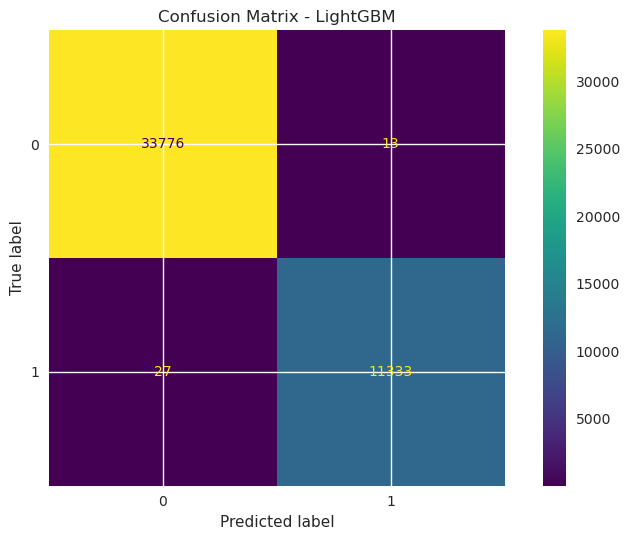

In [42]:
lgb_model = lgb.LGBMClassifier(random_state=42, n_estimators=100)
lgb_model.fit(X_train, y_train)
y_lgb = lgb_model.predict(X_test)
print("LightGBM Classification Report:")
print(classification_report(y_test, y_lgb))
ConfusionMatrixDisplay.from_estimator(lgb_model, X_test, y_test)
plt.title("Confusion Matrix - LightGBM")
plt.tight_layout()
plt.show()

## 4.2. Random forest

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     33789
           1       1.00      1.00      1.00     11360

    accuracy                           1.00     45149
   macro avg       1.00      1.00      1.00     45149
weighted avg       1.00      1.00      1.00     45149



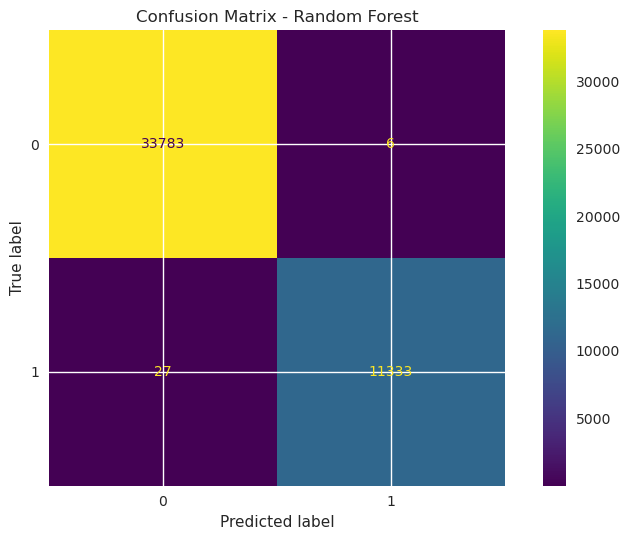

In [43]:
rf = RandomForestClassifier(n_estimators=100, random_state=3)
rf.fit(X_train, y_train)
y_rf = rf.predict(X_test)
print("Random Forest Classification Report:")
print(classification_report(y_test, y_rf))
ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test)
plt.title("Confusion Matrix - Random Forest")
plt.tight_layout()
plt.show()

# 5. Anomaly detection & Unsupervised learning

## 5.1. Principal component analysis

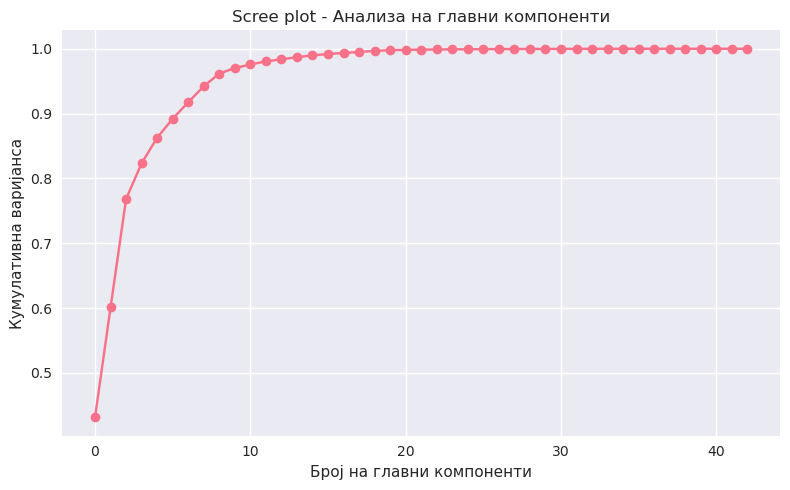

Number of components to retain ~95% variance: 9


In [44]:
from sklearn.decomposition import PCA

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# fituvanje na trening m-vo
pca = PCA()
pca.fit(X_train)

# scree plot
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Број на главни компоненти')
plt.ylabel('Кумулативна варијанса')
plt.title('Scree plot - Анализа на главни компоненти')
plt.grid(True)
plt.tight_layout()
plt.show()

n_components_95 = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.95) + 1
print(f"Number of components to retain ~95% variance: {n_components_95}")

pca = PCA(n_components=n_components_95)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

## 5.2. Insight in PCA space

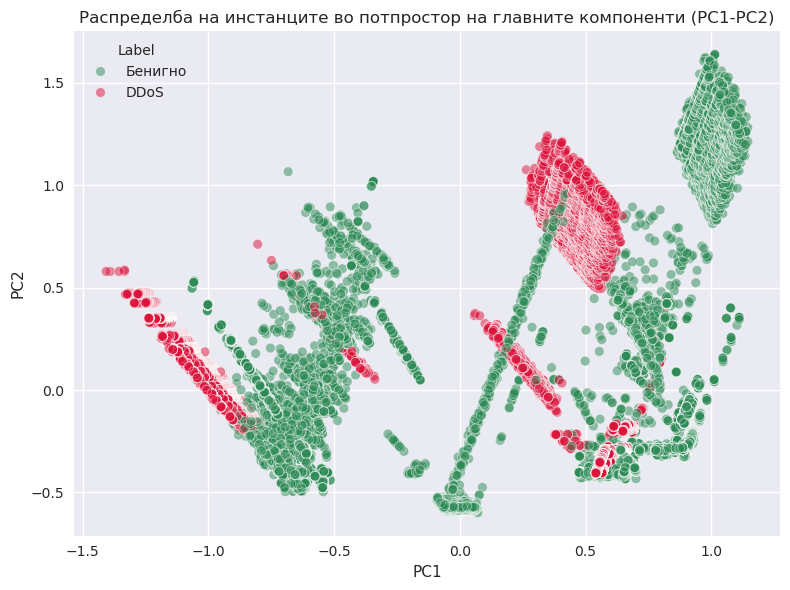

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

df_vis = pd.DataFrame(X_train_pca[:, :2], columns=['PC1', 'PC2'])
df_vis['Label'] = y_train.values

label_map = {0: 'Бенигно', 1: 'DDoS'}
df_vis['Label'] = df_vis['Label'].map(label_map)

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_vis, x='PC1', y='PC2', hue='Label', alpha=0.5, palette={'Бенигно': '#2E8B57', 'DDoS': '#DC143C'})
plt.title('Распределба на инстанците во потпростор на главните компоненти (PC1-PC2)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [46]:
feature_names = df.drop(columns=undesirables+[' Timestamp',' Label']).columns
# comp loadings
loadings = pd.DataFrame(pca.components_[:2], columns=feature_names, index=['PC1', 'PC2'])

In [47]:
loadings.loc['PC1'].abs().sort_values(ascending=False).head(8)

ACK Flag Count            0.589667
PSH Flag Count            0.587687
Average Packet Size       0.271192
Packet Length Std         0.230240
URG Flag Count            0.230219
Avg Bwd Segment Size      0.170827
Packet Length Variance    0.153011
Idle Max                  0.129315
Name: PC1, dtype: float64

In [48]:
loadings.loc['PC2'].abs().sort_values(ascending=False).head(8)

Fwd IAT Total              0.460690
 Idle Max                  0.415986
 Packet Length Std         0.387523
 Average Packet Size       0.309846
 Idle Std                  0.275545
 Avg Bwd Segment Size      0.220764
 Packet Length Variance    0.216925
 Idle Min                  0.203827
Name: PC2, dtype: float64

## 5.3. Clustering analysis

In [49]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.metrics import homogeneity_completeness_v_measure

# Fit GMM on the PCA-transformed training set
gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=42)
gmm.fit(X_train_pca)

# Predict clusters on test set
gmm_preds = gmm.predict(X_test_pca)

# Internal cluster validation against ground truth
ari = adjusted_rand_score(y_test, gmm_preds)
nmi = normalized_mutual_info_score(y_test, gmm_preds)
hom, comp, v_meas = homogeneity_completeness_v_measure(y_test, gmm_preds)

print("Gaussian Mixture Clustering Evaluation:")
print(f"Adjusted Rand Index (ARI): {ari:.4f}")
print(f"Normalized Mutual Info (NMI): {nmi:.4f}")
print(f"Homogeneity: {hom:.4f}, Completeness: {comp:.4f}, V-measure: {v_meas:.4f}")

Gaussian Mixture Clustering Evaluation:
Adjusted Rand Index (ARI): 0.0590
Normalized Mutual Info (NMI): 0.0256
Homogeneity: 0.0279, Completeness: 0.0236, V-measure: 0.0256


In [59]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.metrics import homogeneity_completeness_v_measure

dbscan = DBSCAN(eps=0.03, min_samples=100)
dbscan_preds = dbscan.fit_predict(X_test_pca)

# Remove noise points (-1) for evaluation (optional)
mask = dbscan_preds != -1
dbscan_preds_eval = dbscan_preds[mask]
y_test_eval = y_test[mask]

# Evaluate clustering performance
ari = adjusted_rand_score(y_test_eval, dbscan_preds_eval)
nmi = normalized_mutual_info_score(y_test_eval, dbscan_preds_eval)
hom, comp, v_meas = homogeneity_completeness_v_measure(y_test_eval, dbscan_preds_eval)

print("DBSCAN Clustering Evaluation:")
print(f"Adjusted Rand Index (ARI): {ari:.4f}")
print(f"Normalized Mutual Info (NMI): {nmi:.4f}")
print(f"Homogeneity: {hom:.4f}, Completeness: {comp:.4f}, V-measure: {v_meas:.4f}")

# Noise stats
n_noise = sum(dbscan_preds == -1)
print(f"Noise points: {n_noise} / {len(dbscan_preds)} ({n_noise / len(dbscan_preds) * 100:.2f}%)")

DBSCAN Clustering Evaluation:
Adjusted Rand Index (ARI): 0.1795
Normalized Mutual Info (NMI): 0.3114
Homogeneity: 0.9176, Completeness: 0.1875, V-measure: 0.3114
Noise points: 12360 / 45149 (27.38%)


Homogeneity 91.76% suggests DBScan's ability to distinguish between DDoS

In [60]:
noise_mask = dbscan_preds == -1
noise_labels = y_test[noise_mask]
print(pd.Series(noise_labels).value_counts())

 Label
0    10948
1     1412
Name: count, dtype: int64


In [62]:
print(f"{10948/33789*100}% of benign sessions labeled as noise/outliers")
print(f"{1412/11360*100}% of DDoS sessions labeled as noise/outliers")

32.401077273668946% of benign sessions labeled as noise/outliers
12.429577464788732% of DDoS sessions labeled as noise/outliers


This observation suggests that the majority of DDoS traffic tends to exhibit highly consistent and structured behavioral patterns, which leads to its clustering by the DBSCAN algorithm. From a cybersecurity standpoint, this aligns with the nature of DDoS attacks, which are often automated and executed using scripts or botnets that generate uniform traffic characteristics. These attack flows are typically marked by high packet rates, consistent destination targets, fixed payload sizes, or synchronized timing patterns, all of which contribute to their detectability as cohesive clusters in feature space.

Furthermore, such homogeneity is a defining trait of volumetric DDoS attacks, which aim to overwhelm network resources through repetition and scale. Because of this uniformity, unsupervised models like DBSCAN can effectively group these flows together, distinguishing them from the more diverse and unpredictable behavior found in legitimate network traffic. This reinforces the idea that clustering methods can be especially effective for identifying structured and repetitive cyberattack signatures, even without labeled training data.

## 5.4. Analysis of Benign outliers

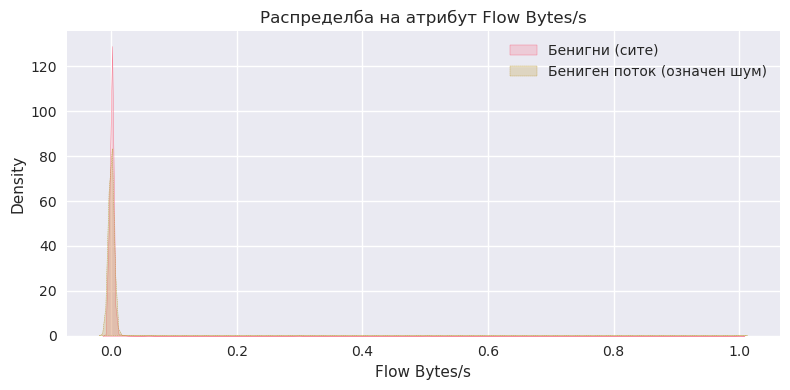

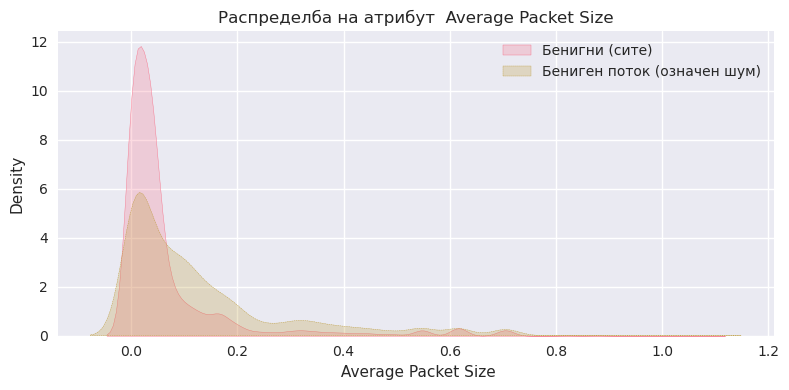

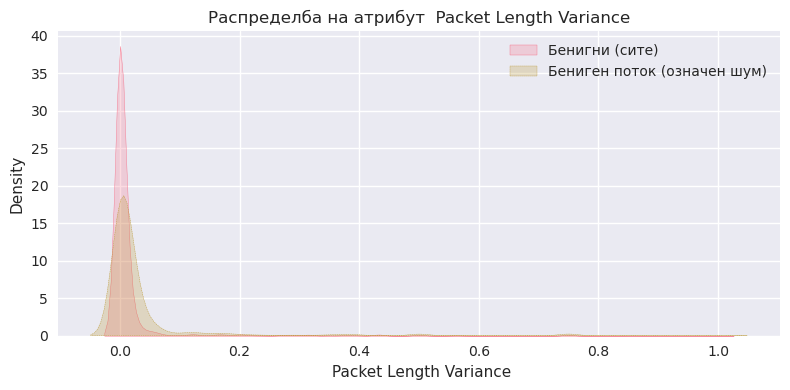

In [71]:
# maskiraj benigni
benign_noise_idx = (y_test == 0) & noise_mask
benign_noise = X_test[benign_noise_idx]

# dfs
df_benign_total = pd.DataFrame(X_test[y_test == 0], columns=feature_names)
df_benign_noise = pd.DataFrame(benign_noise, columns=feature_names)

# plot
def compare_feature_distribution(feature):
    plt.figure(figsize=(8, 4))
    sns.kdeplot(df_benign_total[feature], label='Бенигни (сите)', fill=True)
    sns.kdeplot(df_benign_noise[feature], label='Бениген поток (означен шум)', fill=True, linestyle='--')
    plt.title(f'Распределба на атрибут {feature}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

features_to_plot = ['Flow Bytes/s', ' Average Packet Size', ' Packet Length Variance']

for feat in features_to_plot:
    compare_feature_distribution(feat)